In [6]:
from sklearn.linear_model import LogisticRegression
from IPython.html.widgets import interact
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# How the decision boundary affects classifier performance

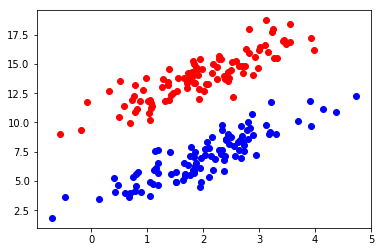

In [13]:
n_points = 100
a_x = np.random.randn(n_points) + 2
a_y = 2 * a_x + 3 + np.random.randn(n_points)

b_x = np.random.randn(n_points) + 2
b_y = 2 * b_x + 10 + np.random.randn(n_points)

fig, ax = plt.subplots()
ax.plot(a_x, a_y, 'bo')
ax.plot(b_x, b_y, 'ro')

In [14]:
# Stack these datapoints and fit a classifier on the data
X = np.hstack([[a_x, a_y], [b_x, b_y]]).T
y = np.ones(X.shape[0])
y[n_points:] = 0

model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now we can visualize the separating hyperplane that this model has discovered in the data.

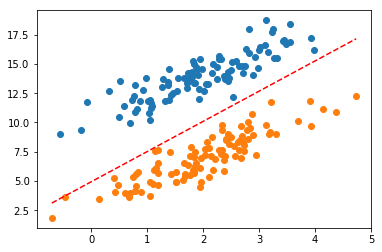

In [21]:
# Plot the line
w = model.coef_[0]
a = -w[0] / float(w[1])
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
yy = a * xx - (model.intercept_[0]) / float(w[1])

fig, ax = plt.subplots()
ax.plot(b_x, b_y, 'o')
ax.plot(a_x, a_y, 'o')
ax.plot(xx, yy, 'r--')

Below we can perform the classification using a number of offset parameters for the decision boundary. This is similar to how ROC curves are constructed. One would compare the true-positives vs. false-positives for each position of the decision boundary, constructing the ROC curve in the process.

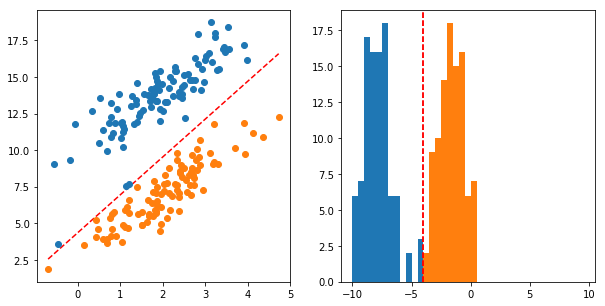

In [18]:
def plot_distributions(intercept=model.intercept_[0]):    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the line for this intercept
    w = model.coef_[0]
    a = -w[0] / float(w[1])
    xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    yy = a * xx - (intercept) / float(w[1])
    axs[0].plot(xx, yy, 'r--')
    
    # Calculate projections
    projection = np.dot(X, w)
    predictions = np.where((projection + intercept) < 0, -1, 1)

    # Plot histograms of each class
    for label in np.unique(predictions):
        this_proj = projection[predictions == label]
        this_pts = X[predictions == label]

        axs[0].plot(this_pts[:, 0], this_pts[:, 1], 'o')
        axs[1].hist(this_proj, bins=np.arange(-10, 10, .5))
        axs[1].axvline(-intercept, color='r', ls='--')

interact(plot_distributions, intercept=[-10., 10., .1],)